# Composing Contracts II

Toying with ideas from [How to Write a Financial Contract](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.14.7885) by S. L. Peyton Jones and J-M. Eber. There is an old version of the paper [Composing Contracts:An Adventure in Financial Engineering](https://www.cs.tufts.edu/~nr/cs257/archive/simon-peyton-jones/contracts.pdf) by Jones, Eber and Seward. Some code for this version can be found in [Composing Contracts](./Composing%20Contracts.ipynb).

In [1]:
from typing import TypeVar, Generic, Union
from dataclasses import dataclass, asdict, astuple
from abc import ABC, abstractmethod
from datetime import datetime

## Observable Floats and Visitor ABC

In [2]:
T = TypeVar('T')


class ObservableFloat(ABC):

    @abstractmethod
    def accept(self, visitor: 'ObservableFloatVisitor') -> T:
        pass


@dataclass
class Konst(ObservableFloat):
    constant: float

    def accept(self, visitor: 'ObservableFloatVisitor') -> T:
        return visitor.konst(self.constant)


@dataclass
class Stock(ObservableFloat):
    ticker: str
    
    def accept(self, visitor: 'ObservableFloatVisitor') -> T:
        return visitor.stock(self.ticker)


class ObservableFloatVisitor(ABC, Generic[T]):
    
    @abstractmethod
    def konst(self, constant: float) -> T: pass

    @abstractmethod
    def stock(self, ticker: str) -> T: pass
    
    def __call__(self, observable: ObservableFloat) -> T:
        return observable.accept(self)

## Observable Booleans and Visitor ABC

In [3]:
T = TypeVar('T')


class ObservableBool(ABC):

    @abstractmethod
    def accept(self, visitor: 'ObservableBoolVisitor') -> T:
        pass


@dataclass
class KonstBool(ObservableBool):
    constant: bool

    def accept(self, visitor: 'ObservableBoolVisitor') -> T:
        return visitor.konst_bool(self.constant)

@dataclass
class At(ObservableBool):
    date: datetime

    def accept(self, visitor: 'ObservableBoolVisitor') -> T:
        return visitor.at(self.date)


class ObservableBoolVisitor(ABC, Generic[T]):
    
    @abstractmethod
    def konst_bool(self, constant: bool) -> T: pass

    @abstractmethod
    def at(self, date: datetime) -> T: pass
    
    def __call__(self, observable: ObservableBool) -> T:
        return observable.accept(self)

## Contracts and Visitor ABC

In [4]:
S, T = TypeVar('S'), TypeVar('T')


class Contract(ABC):

    @abstractmethod
    def accept(self, arg: S, visitor: 'ContractVisitor') -> T:
        pass


@dataclass
class Zero(Contract):

    def accept(self, arg: S, visitor: 'ContractVisitor') -> T:
        return visitor.zero(arg)


@dataclass
class One(Contract):
    currency: str

    def accept(self, arg: S, visitor: 'ContractVisitor') -> T:
        return visitor.one(arg, self.currency)


@dataclass
class Give(Contract):
    contract: Contract

    def accept(self, arg: S, visitor: 'ContractVisitor') -> T:
        return visitor.give(arg, self.contract)


@dataclass
class And(Contract):
    contract1: Contract
    contract2: Contract

    def accept(self, arg: S, visitor: 'ContractVisitor') -> T:
        return visitor.and_(arg, self.contract1, self.contract2)


@dataclass
class Or(Contract):
    contract1: Contract
    contract2: Contract

    def accept(self, arg: S, visitor: 'ContractVisitor') -> T:
        return visitor.or_(arg, self.contract1, self.contract2)


@dataclass
class Cond(Contract):
    observable: ObservableBool
    contract1: Contract
    contract2: Contract

    def accept(self, arg: S, visitor: 'ContractVisitor') -> T:
        return visitor.cond(arg, self.observable, self.contract1, self.contract2)


@dataclass
class Scale(Contract):
    observable: ObservableFloat
    contract: Contract

    def accept(self, arg: S, visitor: 'ContractVisitor') -> T:
        return visitor.scale(arg, self.observable, self.contract)

    
@dataclass
class When(Contract):
    observable: ObservableBool
    contract: Contract

    def accept(self, arg: S, visitor: 'ContractVisitor') -> T:
        return visitor.when(arg, self.observable, self.contract)


@dataclass
class Anytime(Contract):
    observable: ObservableBool
    contract: Contract

    def accept(self, arg: S, visitor: 'ContractVisitor') -> T:
        return visitor.anytime(arg, self.observable, self.contract)


@dataclass
class Until(Contract):
    observable: ObservableBool
    contract: Contract

    def accept(self, arg: S, visitor: 'ContractVisitor') -> T:
        return visitor.until(arg, self.observable, self.contract)


class ContractVisitor(ABC, Generic[S, T]):

    @abstractmethod
    def zero(self, arg: S) -> T: pass

    @abstractmethod
    def one(self, arg: S, currency: str) -> T: pass

    @abstractmethod
    def give(self, arg: S, contract: Contract) -> T: pass

    @abstractmethod
    def and_(self, arg: S, contract1: Contract, contract2: Contract) -> T: pass

    @abstractmethod
    def or_(self, arg: S, contract1: Contract, contract2: Contract) -> T: pass

    @abstractmethod
    def cond(self, acquisition_date: datetime, observable: ObservableBool, contract1: Contract, contract2: Contract) -> T: pass

    @abstractmethod
    def scale(self, arg: S, observable: ObservableFloat, contract: Contract) -> T: pass

    @abstractmethod
    def when(self, arg: S, observable: ObservableBool, contract: Contract) -> T: pass

    @abstractmethod
    def anytime(self, arg: S, observable: ObservableBool, contract: Contract) -> T: pass

    @abstractmethod
    def until(self, arg: S, observable: ObservableBool, contract: Contract) -> T: pass

    def __call__(self, arg: S, contract: Contract) -> T:
        return contract.accept(arg, self)

## A Simple Printer Implementation of Visitors

In [5]:
class ObservableFloatPrinter(ObservableFloatVisitor[str]):
    def konst(self, constant: float) -> str: return str(constant)
    def stock(self, ticker: str) -> str: return f'"{ticker}"'

In [6]:
class ObservableBoolPrinter(ObservableBoolVisitor[str]):
    def konst_bool(self, constant: bool) -> str: return str(constant)
    def at(self, date: datetime) -> str: return f'"{date}"'

In [7]:
class ContractPrinter(ContractVisitor[None, str]):
    
    def __init__(self,
                 observable_float_visitor: ObservableFloatVisitor[str],
                 observable_bool_visitor: ObservableBoolVisitor[str]) -> None:
        self.observable_float_visitor = observable_float_visitor
        self.observable_bool_visitor = observable_bool_visitor
    
    def zero(self, acquisition_date) -> str: return 'zero'
    def one(self, acquisition_date, currency: str) -> str: return f'one {currency}'
    def give(self, acquisition_date, contract: Contract) -> str: return f'give ({self(acquisition_date, contract)})'
    def and_(self, acquisition_date, contract1: Contract, contract2: Contract) -> str: return f'and ({self(acquisition_date, contract1)}) ({self(acquisition_date, contract2)})'
    def or_(self, acquisition_date, contract1: Contract, contract2: Contract) -> str: return f'or ({self(acquisition_date, contract1)}) ({self(acquisition_date, contract2)})'
    def cond(self, acquisition_date, observable: ObservableBool, contract1: Contract, contract2: Contract) -> str: return f'cond ({self.observable_bool_visitor(observable)}) ({self(acquisition_date, contract1)}) ({self(acquisition_date, contract2)})'
    def scale(self, acquisition_date, observable: ObservableFloat, contract: Contract) -> str: return f'scale {self.observable_float_visitor(observable)} ({self(acquisition_date, contract)})'
    def when(self, acquisition_date, observable: ObservableBool, contract: Contract) -> str: return f'when {self.observable_bool_visitor(observable)} ({self(acquisition_date, contract)})'
    def anytime(self, acquisition_date, observable: ObservableBool, contract: Contract) -> str: return f'anytime {self.observable_bool_visitor(observable)} ({self(acquisition_date, contract)})'
    def until(self, acquisition_date, observable: ObservableBool, contract: Contract) -> str: return f'until {self.observable_bool_visitor(observable)} ({self(acquisition_date, contract)})'


## Examples

In [8]:
def zcb(maturity: datetime, notional: float, currency: str):
    return When(At(maturity), Scale(Konst(notional), One(currency)))

In [9]:
def european(maturity: datetime, contract: Contract):
    return When(At(maturity), Or(contract, Zero()))

In [10]:
mybond1 = zcb(datetime(2030, 7, 14), 1000000, 'EUR')
mybond1

When(observable=At(date=datetime.datetime(2030, 7, 14, 0, 0)), contract=Scale(observable=Konst(constant=1000000), contract=One(currency='EUR')))

In [11]:
printer = ContractPrinter(ObservableFloatPrinter(), ObservableBoolPrinter())
printer(None, mybond1)

'when "2030-07-14 00:00:00" (scale 1000000 (one EUR))'

In [12]:
asdict(mybond1)

{'observable': {'date': datetime.datetime(2030, 7, 14, 0, 0)},
 'contract': {'observable': {'constant': 1000000},
  'contract': {'currency': 'EUR'}}}

In [13]:
astuple(mybond1)

((datetime.datetime(2030, 7, 14, 0, 0),), ((1000000,), ('EUR',)))

In [14]:
dict(**mybond1.__dict__)

{'observable': At(date=datetime.datetime(2030, 7, 14, 0, 0)),
 'contract': Scale(observable=Konst(constant=1000000), contract=One(currency='EUR'))}

In [15]:
def european_put(ticker: str, currency: str, maturity: datetime, strike: float):
    return When(At(maturity), Or(
        And(Give(Scale(Stock(ticker), One(currency))), Scale(Konst(strike), One(currency))),
        Zero()))

In [16]:
myput1 = european_put('ABC Eqty', 'USD', datetime(2030, 7, 14), 123.45)
myput1

When(observable=At(date=datetime.datetime(2030, 7, 14, 0, 0)), contract=Or(contract1=And(contract1=Give(contract=Scale(observable=Stock(ticker='ABC Eqty'), contract=One(currency='USD'))), contract2=Scale(observable=Konst(constant=123.45), contract=One(currency='USD'))), contract2=Zero()))

In [17]:
printer(None, myput1)

'when "2030-07-14 00:00:00" (or (and (give (scale "ABC Eqty" (one USD))) (scale 123.45 (one USD))) (zero))'

## Simulated Cashflows

In [18]:
import numpy as np

In [19]:
cashflow_dtype = np.dtype([('date', 'datetime64[D]'), ('currency', np.string_, 3), ('value', np.float64)])
cashflow_dtype

dtype([('date', '<M8[D]'), ('currency', 'S3'), ('value', '<f8')])

In [20]:
cf = np.array([(datetime(2030, 7, 14), 'USD', 123.45), (datetime(2031, 7, 14), 'USD', 123.45)], cashflow_dtype)
cf = cf.reshape((cf.size, 1))
cf

array([[('2030-07-14', b'USD', 123.45)],
       [('2031-07-14', b'USD', 123.45)]],
      dtype=[('date', '<M8[D]'), ('currency', 'S3'), ('value', '<f8')])

In [21]:
multicf = np.concatenate((cf, cf, cf), axis=1)
multicf.shape

(2, 3)

In [22]:
multicf['date'] == np.datetime64(datetime(2031, 7, 14))

array([[False, False, False],
       [ True,  True,  True]])

In [23]:
multicf[multicf['date'] == np.datetime64(datetime(2031, 7, 14))]['value'] = 888 # does not modify
multicf

array([[('2030-07-14', b'USD', 123.45), ('2030-07-14', b'USD', 123.45),
        ('2030-07-14', b'USD', 123.45)],
       [('2031-07-14', b'USD', 123.45), ('2031-07-14', b'USD', 123.45),
        ('2031-07-14', b'USD', 123.45)]],
      dtype=[('date', '<M8[D]'), ('currency', 'S3'), ('value', '<f8')])

In [24]:
multicf['value'][multicf['date'] == np.datetime64(datetime(2031, 7, 14))] = 999 # does modify
multicf

array([[('2030-07-14', b'USD', 123.45), ('2030-07-14', b'USD', 123.45),
        ('2030-07-14', b'USD', 123.45)],
       [('2031-07-14', b'USD', 999.  ), ('2031-07-14', b'USD', 999.  ),
        ('2031-07-14', b'USD', 999.  )]],
      dtype=[('date', '<M8[D]'), ('currency', 'S3'), ('value', '<f8')])

## Simulated Stochastic Processes

In [25]:
import numpy as np


class BrownianMotion:
    '''Brownian Motion (Wiener Process) with optional drift.'''
    def __init__(self, mu: float=0.0, sigma: float=1.0):
        self.mu = mu
        self.sigma = sigma

    def simulate(self, t: np.array, n: int, rnd: np.random.RandomState) \
            -> np.array:
        assert t.ndim == 1, 'One dimensional time vector required'
        assert t.size > 0, 'At least one time point is required'
        dt = np.concatenate((t[0:1], np.diff(t)))
        assert (dt >= 0).all(), 'Increasing time vector required'
        # transposed simulation for automatic broadcasting
        W = rnd.normal(size=(n, t.size))
        W_drift = (W * np.sqrt(dt) * self.sigma + self.mu * dt)
        return np.cumsum(W_drift, axis=1)


class GeometricBrownianMotion:
    '''Geometric Brownian Motion.(with optional drift).'''
    def __init__(self, mu: float=0.0, sigma: float=1.0):
        self.mu = mu
        self.sigma = sigma

    def simulate(self, t: np.array, n: int, rnd: np.random.RandomState) \
            -> np.array:
        assert t.ndim == 1, 'One dimensional time vector required'
        assert t.size > 0, 'At least one time point is required'
        dt = np.concatenate((t[0:1], np.diff(t)))
        assert (dt >= 0).all(), 'Increasing time vector required'
        # transposed simulation for automatic broadcasting
        dW = (rnd.normal(size=(t.size, n)).T * np.sqrt(dt)).T
        W = np.cumsum(dW, axis=0)
        return np.exp(self.sigma * W.T + (self.mu - self.sigma**2 / 2) * t)

## Fixed Grid Simulation Model

In [26]:
class FixedGridSimulationModel(ObservableFloatVisitor[np.array], ObservableBoolVisitor[np.array]):
    
    def __init__(self, dategrid, simulated_underlyings):
        self.dategrid = np.reshape(dategrid, (1, dategrid.size))
        self.simulated_underlyings = simulated_underlyings
        self.shape = list(self.simulated_underlyings.values())[0].shape
    
    def mask(self, acquisition_date):
        return np.repeat(self.dategrid, self.shape[0], axis=0) == acquisition_date
    
    def konst(self, constant: float) -> np.array:
        return constant * np.ones(self.shape)
    
    def stock(self, ticker: str) -> np.array:
        return self.simulated_underlyings[ticker]
    
    def konst_bool(self, constant: bool) -> np.array:
        return constant * np.ones(self.shape, dtype=np.bool)
    
    def at(self, date: datetime) -> np.array:
        mask = self.dategrid == np.datetime64(date)
        assert mask.any(), f'{date} not contained in dategrid'
        return np.repeat(mask, self.shape[0], axis=0)

In [27]:
class FixedGridSimulationCashflowGenerator(ContractVisitor[Union[datetime, np.array], np.array]):
    
    def __init__(self, model):
        self.model = model
        self.N = self.model.shape[0]
    
    def zero(self, acquisition_date) -> np.array:
        cf = np.zeros((N, 1), dtype=cashflow_dtype)
        cf['currency'] = 'NNN'
        cf['date'] = acquisition_date
        return cf

    def one(self, acquisition_date, currency: str) -> np.array:
        cf = np.ones((N, 1), dtype=cashflow_dtype)
        cf['currency'] = currency
        cf['date'] = acquisition_date
        return cf

    def give(self, acquisition_date, contract: Contract) -> np.array:
        cf = self(acquisition_date, contract)
        cf['value'] *= -1
        return cf

    def and_(self, acquisition_date, contract1: Contract, contract2: Contract) -> np.array:
        cf1 = self(acquisition_date, contract1)
        cf2 = self(acquisition_date, contract2)
        return np.concatenate((cf1, cf2), axis=1)

    def or_(self, acquisition_date, contract1: Contract, contract2: Contract) -> np.array:
        raise NotImplementedError()

    def cond(self, acquisition_date, observable: ObservableBool, contract1: Contract, contract2: Contract) -> np.array:
        raise NotImplementedError()

    def scale(self, acquisition_date, observable: ObservableFloat, contract: Contract) -> np.array:
        cf = self(acquisition_date, contract)
        cf['value'] *= observable.accept(self.model)[self.model.mask(acquisition_date)]
        return cf

    def when(self, acquisition_date, observable: ObservableBool, contract: Contract) -> np.array:
        raise NotImplementedError()

    def anytime(self, acquisition_date, observable: ObservableBool, contract: Contract) -> np.array:
        raise NotImplementedError()

    def until(self, acquisition_date, observable: ObservableBool, contract: Contract) -> np.array:
        raise NotImplementedError()


In [28]:
N = 100
rnd = np.random.RandomState(123)
T = 5
evaldate = np.datetime64('2020-07-14')
dategrid = np.array([evaldate + np.timedelta64(i * 365) for i in range(0, 11)])
yfgrid = np.cumsum(np.diff(np.concatenate((dategrid[0:1], dategrid))) / 365).astype(np.float64)

In [29]:
simulated_underlyings = {
    'ABC Eqty': 123 * GeometricBrownianMotion(0.02, 0.2).simulate(yfgrid, N, rnd)
}

In [30]:
import matplotlib.pyplot as plt

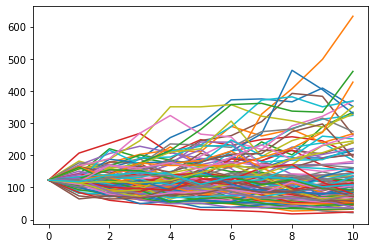

In [31]:
plt.plot(simulated_underlyings['ABC Eqty'].T);

In [32]:
model = FixedGridSimulationModel(dategrid, simulated_underlyings)
cashflow_generator = FixedGridSimulationCashflowGenerator(model)

In [33]:
myput2 = european_put('ABC Eqty', 'USD', dategrid[-1], 123.45)
myput2

When(observable=At(date=numpy.datetime64('2030-07-12')), contract=Or(contract1=And(contract1=Give(contract=Scale(observable=Stock(ticker='ABC Eqty'), contract=One(currency='USD'))), contract2=Scale(observable=Konst(constant=123.45), contract=One(currency='USD'))), contract2=Zero()))

In [34]:
Konst(1).accept(model).shape

(100, 11)

In [35]:
model.mask(evaldate).shape

(100, 11)

In [36]:
Konst(1).accept(model)[model.mask(evaldate)]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [37]:
cashflow_generator(evaldate, And(Scale(Konst(1.23), One('EUR')), Give(One('USD'))))

ValueError: non-broadcastable output operand with shape (100,1) doesn't match the broadcast shape (100,100)